In [1]:
from phi.flow import *
from matplotlib import pyplot as plt
import numpy as np
import random

C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\site-packages\phi\viz\display.py:78: UserWarning: GUI is disabled because of missing dependencies: No module named 'dash_core_components'. To install all dependencies, run $ pip install phiflow[gui]
  warnings.warn('GUI is disabled because of missing dependencies: %s. To install all dependencies, run $ pip install phiflow[gui]' % import_error)


In [2]:
step_count = 16  # how many solver steps to perform
domain = Domain([64, 64])
dt = 1.0
data_path = 'shape-transitions'
test_range = range(100)
val_range = range(100, 200)
train_range = range(200, 1000)

In [3]:
supervised_checkpoints = {'OP%d' % n: 'ckpts/supervised/OP%d_1000' % n for n in [2, 4, 8, 16]}
supervised_checkpoints['CFE'] = 'ckpts/CFE/CFE_1000'

In [4]:
from src.control.control_training import ControlTraining
from src.control.pde.incompressible_flow import IncompressibleFluidPDE
from src.control.sequences import StaggeredSequence

staggered_app = ControlTraining(step_count, IncompressibleFluidPDE(domain, dt),
                                datapath=data_path, val_range=val_range, train_range=train_range,
                                trace_to_channel=lambda _: 'density',
                                obs_loss_frames=[step_count], trainable_networks=['CFE', 'OP2', 'OP4', 'OP8', 'OP16'],
                                sequence_class=StaggeredSequence, learning_rate=5e-4).prepare()
staggered_app.load_checkpoints(supervised_checkpoints)
for i in range(1000):
    staggered_app.progress()  # run staggered Optimization for one batch
staggered_checkpoint = staggered_app.save_model()

C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\s

Could not load resample cuda libraries: CUDA binaries not found at C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\site-packages\phi\tf\cuda/build/resample.so. Run "python setup.py cuda" to compile them






C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\xayah\Desktop\DeepD

App created. Scene directory is C:\Users\xayah/phi/model/control-training\sim_000016 (INFO), 2025-02-25 01:04:17,021n


Sequence class: <class 'src.control.sequences.StaggeredSequence'> (INFO), 2025-02-25 01:04:17,656n

Partition length 16 sequence (from 0 to 16) at frame 8
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\site-packages\phi\struct\context.py:18: UserWarning: struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.
  warnings.warn("struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.")



Partition length 8 sequence (from 0 to 8) at frame 4
Partition length 4 sequence (from 0 to 4) at frame 2
Partition length 2 sequence (from 0 to 2) at frame 1
Execute -> 1
Execute -> 2
Partition length 2 sequence (from 2 to 4) at frame 3
Execute -> 3
Execute -> 4
Partition length 4 sequence (from 4 to 8) at frame 6
Partition length 2 sequence (from 4 to 6) at frame 5
Execute -> 5
Execute -> 6
Partition length 2 sequence (from 6 to 8) at frame 7
Execute -> 7
Execute -> 8
Partition length 8 sequence (from 8 to 16) at frame 12
Partition length 4 sequence (from 8 to 12) at frame 10
Partition length 2 sequence (from 8 to 10) at frame 9
Execute -> 9
Execute -> 10
Partition length 2 sequence (from 10 to 12) at frame 11
Execute -> 11
Execute -> 12
Partition length 4 sequence (from 12 to 16) at frame 14
Partition length 2 sequence (from 12 to 14) at frame 13
Execute -> 13
Execute -> 14
Partition length 2 sequence (from 14 to 16) at frame 15
Execute -> 15
Execute -> 16
Instructions for updating

C:\Users\xayah\Desktop\DeepDiffFluid\venv37\lib\site-packages\phi\struct\context.py:18: UserWarning: struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.
  warnings.warn("struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.")


Model variables contain 0 total parameters. (INFO), 2025-02-25 01:05:44,144n




Validation (000000): Learning_Rate: 0.0005, GT_obs_16: 387093.06, Loss_reg_unscaled: 0.9627782, Loss_reg_scale: 1.0, Loss: 774186.1 (INFO), 2025-02-25 01:06:04,104n

Loading CFE from ckpts/CFE/CFE_1000... (INFO), 2025-02-25 01:06:04,108n

Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ckpts/CFE/CFE_1000\model.ckpt


INFO:tensorflow:Restoring parameters from ckpts/CFE/CFE_1000\model.ckpt


Loading OP2 from ckpts/supervised/OP2_1000... (INFO), 2025-02-25 01:06:06,113n

INFO:tensorflow:Restoring parameters from ckpts/supervised/OP2_1000\model.ckpt


INFO:tensorflow:Restoring parameters from ckpts/supervised/OP2_1000\model.ckpt


Loading OP4 from ckpts/supervised/OP4_1000... (INFO), 2025-02-25 01:06:08,128n

INFO:tensorflow:Restoring parameters from ckpts/supervised/OP4_1000\model.ckpt


INFO:tensorflow:Restoring parameters from ckpts/supervised/OP4_1000\model.ckpt


Loading OP8 from ckpts/supervised/OP8_1000... (INFO), 2025-02-25 01:06:10,222n

INFO:tensorflow:Restoring parameters from ckpts/supervised/OP8_1000\model.ckpt


INFO:tensorflow:Restoring parameters from ckpts/supervised/OP8_1000\model.ckpt


Loading OP16 from ckpts/supervised/OP16_1000... (INFO), 2025-02-25 01:06:12,278n

INFO:tensorflow:Restoring parameters from ckpts/supervised/OP16_1000\model.ckpt


INFO:tensorflow:Restoring parameters from ckpts/supervised/OP16_1000\model.ckpt


Optimization (000000): Learning_Rate: 0.0005, GT_obs_16: 93987.56, Loss_reg_unscaled: 435.59753, Loss_reg_scale: 1.0, Loss: 187975.12 (INFO), 2025-02-25 01:06:58,033n

Validation (000000): Learning_Rate: 0.0005, GT_obs_16: 47300.02, Loss_reg_unscaled: 479.06134, Loss_reg_scale: 1.0, Loss: 94600.04 (INFO), 2025-02-25 01:07:02,998n

Optimization (000050): Learning_Rate: 0.0005, GT_obs_16: 14087.877, Loss_reg_unscaled: 2284.0059, Loss_reg_scale: 1.0, Loss: 28175.754 (INFO), 2025-02-25 01:07:37,205n

Validation (000050): Learning_Rate: 0.0005, GT_obs_16: 15860.38, Loss_reg_unscaled: 2022.8773, Loss_reg_scale: 1.0, Loss: 31720.76 (INFO), 2025-02-25 01:07:41,675n

Optimization (000100): Learning_Rate: 0.0005, GT_obs_16: 7885.635, Loss_reg_unscaled: 3004.9963, Loss_reg_scale: 1.0, Loss: 15771.27 (INFO), 2025-02-25 01:08:15,461n

Validation (000100): Learning_Rate: 0.0005, GT_obs_16: 11500.932, Loss_reg_unscaled: 2318.6003, Loss_reg_scale: 1.0, Loss: 23001.863 (INFO), 2025-02-25 01:08:19,255n


In [5]:
states = staggered_app.infer_all_frames(test_range)

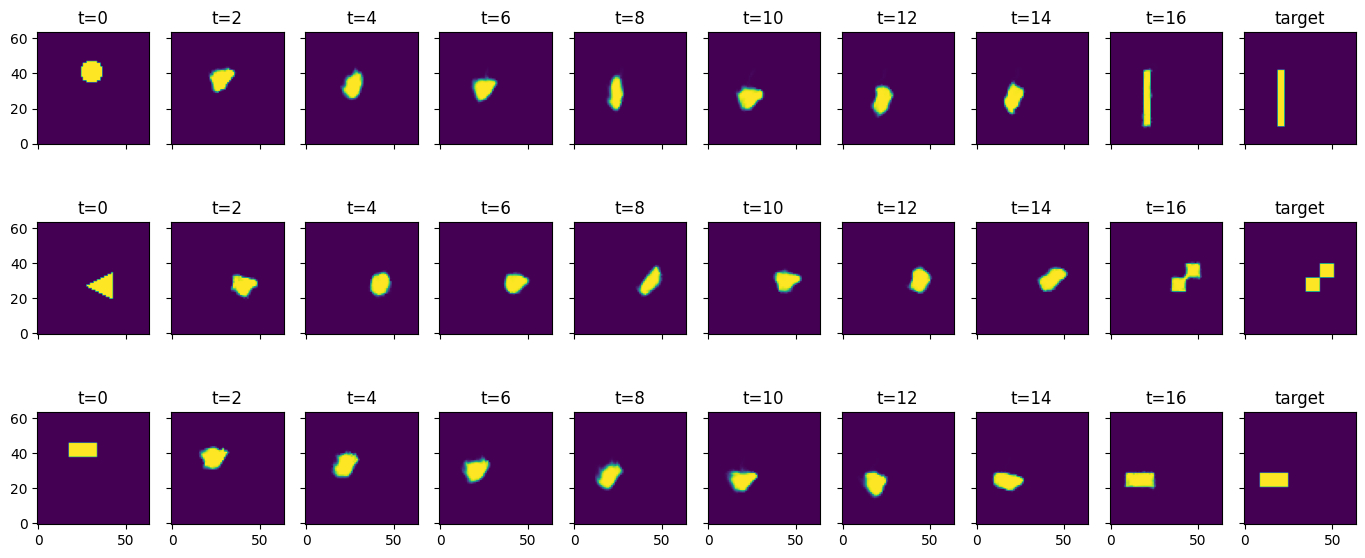

In [6]:
import pylab

batches = [0, 1, 2]

pylab.subplots(len(batches), 10, sharey='row', sharex='col', figsize=(14, 6))
pylab.tight_layout(w_pad=0)

# solutions
for i, batch in enumerate(batches):
    for t in range(9):
        pylab.subplot(len(batches), 10, t + 1 + i * 10)
        pylab.title('t=%d' % (t * 2))
        pylab.imshow(states[t * 2].density.data[batch, ..., 0], origin='lower')

# add targets
testset = BatchReader(Dataset.load(staggered_app.data_path, test_range), staggered_app._channel_struct)[test_range]
for i, batch in enumerate(batches):
    pylab.subplot(len(batches), 10, i * 10 + 10)
    pylab.title('target')
    pylab.imshow(testset[1][i, ..., 0], origin='lower')


In [7]:
errors = []
for batch in enumerate(test_range):
    initial = np.mean( np.abs( states[0].density.data[batch, ..., 0] - testset[1][batch,...,0] ))
    solution = np.mean( np.abs( states[16].density.data[batch, ..., 0] - testset[1][batch,...,0] ))
    errors.append( solution/initial )
print("Relative MAE: "+format(np.mean(errors)))

Relative MAE: 0.06064693629741669
